In [1]:
from scipy.io import loadmat
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from os import path
import os
import cv2
path_to_dataset = "/home/nonari/Descargas/2015_BOE_Chiu/"
for dirname, _, filenames in os.walk(path_to_dataset):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/home/nonari/Descargas/2015_BOE_Chiu/Subject_01.mat
/home/nonari/Descargas/2015_BOE_Chiu/Subject_08.mat
/home/nonari/Descargas/2015_BOE_Chiu/Subject_07.mat
/home/nonari/Descargas/2015_BOE_Chiu/Subject_04.mat
/home/nonari/Descargas/2015_BOE_Chiu/Subject_03.mat
/home/nonari/Descargas/2015_BOE_Chiu/Subject_02.mat
/home/nonari/Descargas/2015_BOE_Chiu/Subject_09.mat
/home/nonari/Descargas/2015_BOE_Chiu/Subject_06.mat
/home/nonari/Descargas/2015_BOE_Chiu/Subject_05.mat
/home/nonari/Descargas/2015_BOE_Chiu/Subject_10.mat


In [2]:
fluid_class = 9


In [3]:
def get_valid_idx(manualLayer):
    idx = []
    for i in range(0,61):
        temp = manualLayer[:,:,i]
        if np.sum(temp) != 0:
            idx.append(i)
    return idx


In [4]:
def get_valid_img_seg(mat):
    manualLayer = np.array(mat['manualLayers1'], dtype=np.uint16)
    manualFluid = np.array(mat['manualFluid1'], dtype=np.uint16)
    img = np.array(mat['images'], dtype=np.uint8)
    valid_idx = get_valid_idx(manualLayer)


    manualFluid = manualFluid[:, :, valid_idx]
    manualLayer = manualLayer[:, :, valid_idx]

    print("Seg shape", manualLayer.shape)

    seg = np.zeros((496, 768, 11))
    seg[manualFluid > 0] = fluid_class
    plt.imshow(seg[:,:,0])
    max_col = -100
    min_col = 900
    for b_scan_idx in range(0, 11):
        for col in range(768):
            cur_col = manualLayer[:, col, b_scan_idx]
            if np.sum(cur_col) == 0:
                continue

            max_col = max(max_col, col)
            min_col = min(min_col, col)

            labels_idx = cur_col.tolist()
    #         print(f'{b_scan_idx} {labels_idx}')
    #         labels_idx.append(-1)
    #         labels_idx.insert(0, 0)
            last_st = 0
            #Correccion: Salta error si el ed del label 0 es None (al principio de la iteracion)

            last_ed = 0
            for label, (st, ed) in enumerate(zip([0]+labels_idx, labels_idx+[-1])):
    #             print(st, ed)
                if st == 0 and ed == 0:
                    st = max(last_ed, last_st)
                    if last_ed is None:
                        print(f"Last ed was none at {col}")
                    while(seg[st, col, b_scan_idx] == fluid_class):
                        st += 1

                    while(seg[st, col, b_scan_idx] != fluid_class):
                        seg[st, col, b_scan_idx] = label
                        st += 1
                        if st >= 496:
                            break
                    continue
                if ed == 0:
                    ed = st + 1
                    while(seg[ed, col, b_scan_idx] != fluid_class):
                        ed += 1

                if st == 0 and label != 0:
                    st = ed-1
                    while(seg[st, col, b_scan_idx] != fluid_class):
                        st -= 1
                    st += 1

                seg[st:ed, col, b_scan_idx] = label
                last_st = st
                last_ed = ed

    seg[manualFluid > 0] = fluid_class

    seg = seg[:, min_col:max_col+1]
    img = img[:, min_col:max_col+1]
    return img, seg, valid_idx

In [5]:
def close_fluid(img):
    zeros = np.where(img == 0)
    for x, y in zip(zeros):
        try:
            if img[x+1, y] == fluid_class:
                img[x+1, y] = fluid_class
        except:
            pass
        try:
            if img[x-1, y] == fluid_class:
                img[x-1, y] = fluid_class
        except:
            pass
        try:
            if img[x, y+1] == fluid_class:
                img[x, y+1] = fluid_class
        except:
            pass
        try:
            if img[x, y-1] == fluid_class:
                img[x, y-1] = fluid_class
        except:
            pass

In [5]:
mat_fps = glob(path.join(path_to_dataset, '*.mat'))

In [6]:
mat = loadmat(mat_fps[0])

In [ ]:
all_img = []
all_lab = []
d = 0
for idx_mat, m in enumerate(mat_fps):
    mat = loadmat(m)
    print("WILL LOAD ANOTHER")
    img, seg, indices = get_valid_img_seg(mat)
    #os.mkdir(f'/home/nonari/Documentos/tfgdata/patient_{idx_mat}', )

    for i in range(img.shape[2]):
        if i in indices:
            plt.imsave(f'/home/nonari/Documentos/tfgdata2/img_{idx_mat}_{i}.png', img[:,:,i], cmap=plt.cm.gray)
    for i in range(len(indices)):
        #close_fluid(seg[:,:,i])
        plt.imsave(f'/home/nonari/Documentos/tfgdata2/seg_{idx_mat}_{indices[i]}.png', seg[:,:,i])
        #cv2.imwrite(f'/home/nonari/Documentos/tfgdata2/seg_{idx_mat}_{indices[i]}.png', seg[:,:,i])
        d += 1


WILL LOAD ANOTHER
Seg shape (8, 768, 11)
WILL LOAD ANOTHER
Seg shape (8, 768, 11)
WILL LOAD ANOTHER
Seg shape (8, 768, 11)
WILL LOAD ANOTHER
Seg shape (8, 768, 11)
WILL LOAD ANOTHER
Seg shape (8, 768, 11)
WILL LOAD ANOTHER
Seg shape (8, 768, 11)
WILL LOAD ANOTHER
Seg shape (8, 768, 11)
WILL LOAD ANOTHER
Seg shape (8, 768, 11)
WILL LOAD ANOTHER
Seg shape (8, 768, 11)


In [55]:
img, seg, indices = get_valid_img_seg(mat)


(8, 768, 11)


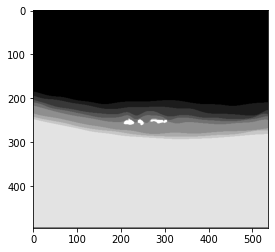

In [25]:
plt.imshow(seg[:, :, 0], cmap=plt.cm.gray, vmax=9)

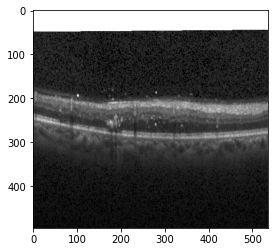

In [26]:
plt.imshow(img[:, :, 10], cmap=plt.cm.gray)

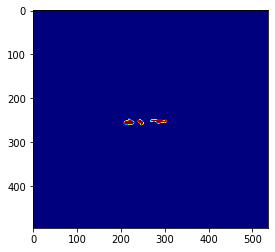

In [53]:
a = seg!=9
seg[a]=0
plt.imshow(seg[:, :, 0], cmap=plt.cm.jet, vmax=9)

In [8]:
mat = loadmat("/home/nonari/Descargas/octmat/archive_amd_oct/control 2/Control 2/Farsiu_Ophthalmology_2013_Control_Subject_1027.mat")

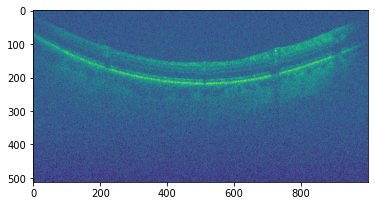

In [9]:
plt.imshow(mat['images'][:,:,0])

In [13]:
lay = mat['layerMaps']

In [17]:
np.sum(lay[:,:,2])

nan

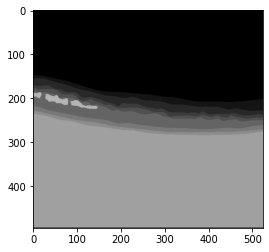

In [5]:
mask = cv2.imread("/home/nonari/Documentos/tfgdata/tfgoct/seg_9_20.png")
plt.imshow(mask*20)
plt.show()